In [6]:
# MANUAL tSNE on MNIST dataset: 
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from tqdm import tqdm

In [4]:
mnist = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())


In [ ]:
# pseudocode: 

# load mnist into matrix X
x = mnist.data.numpy().reshape(-1, 28*28)
y = mnist.targets.numpy()

# sample n images 
n = 20000
np.random.seed(0)
idx = np.random.choice(len(x), n)
x = x[idx]
print(x.shape)

# prep X: 0-1 range; the 0-mean
x = x / 255
x = x - x.mean(axis=0)

# run PCA to 50 dimensions

pca = PCA(n_components=50)
x_pca = pca.fit_transform(x)

# compute pairwise distance matrix D

D = pairwise_distances(x_pca)

# compute similarities p_ij for each row i:
P = np.zeros((n, n))
for i in range(n):
    beta = 0.6
    D_i = D[i, :]
    P_i = np.zeros((1,n))
    # binary like search for beta(i)
    trials = 0
    hdiff = 1
    betamin = -np.inf
    betamax = np.inf
    while(np.abs(hdiff) > 1e-5 and trials < 50):
        P_i = np.exp(-D_i * beta)
        betac = (betamin + betamax) / 2
        h = np.sum(np.exp(-D_i * betac))
        hdiff = h - beta
        if hdiff > 0:
            betamin = betac
        else:
            betamax = betac
        trials += 1
    beta = betac
    P[i, :] = P_i  

# Ensure P is symmetric and normalized
P = (P + P.T) / (2 * n)
P = np.maximum(P, 1e-12)
,
,
,

(20000, 784)
Row 0 does not sum to 1


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0 KL divergence is nan


  0%|          | 0/101 [00:10<?, ?it/s]


KeyboardInterrupt: 

(20000, 784)
Row 0 does not sum to 1


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0 KL divergence is 41057195.28227658


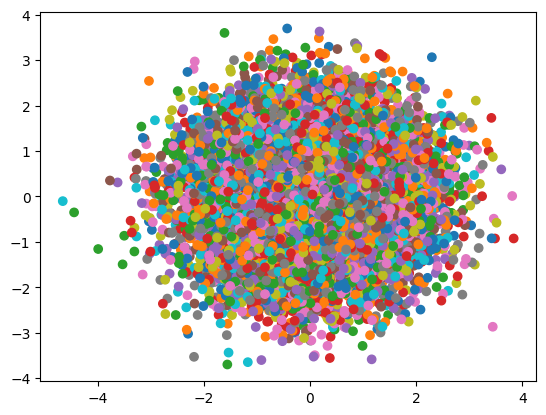

  1%|          | 1/100 [00:23<38:14, 23.18s/it]

Iteration 1 KL divergence is 41057195.22765473


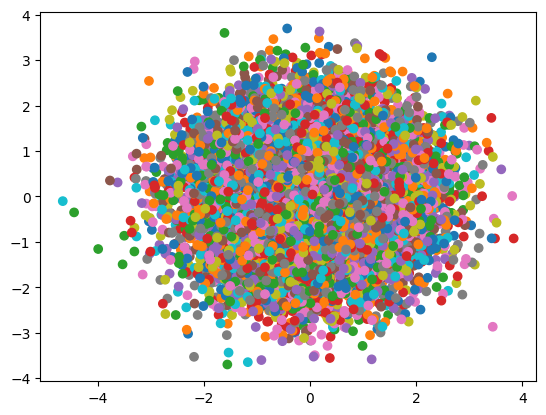

  2%|▏         | 2/100 [00:46<38:22, 23.49s/it]

Iteration 2 KL divergence is 41057167.861693844


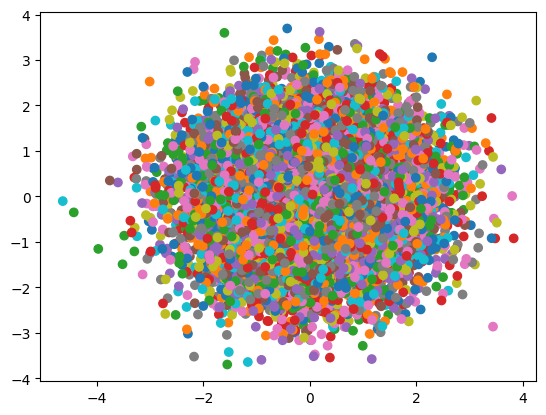

  3%|▎         | 3/100 [01:14<41:00, 25.37s/it]

Iteration 3 KL divergence is 41043451.64105208


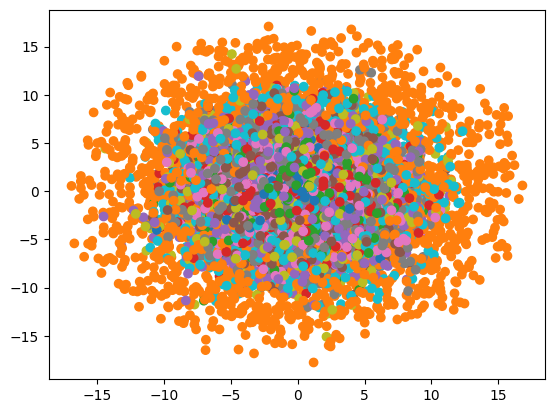

  4%|▍         | 4/100 [01:38<39:37, 24.77s/it]

Iteration 4 KL divergence is 43791375.80011965


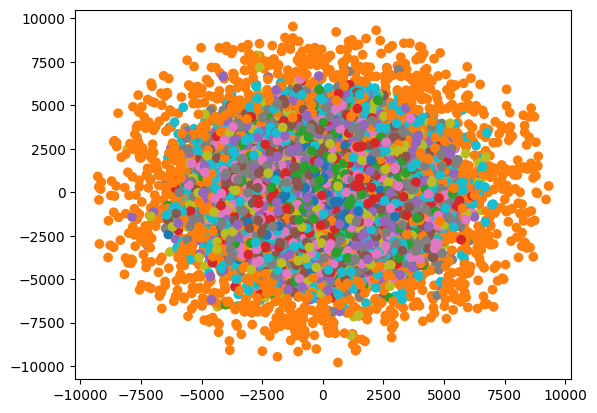

  5%|▌         | 5/100 [02:02<38:46, 24.49s/it]

Iteration 5 KL divergence is 57463067.23306331


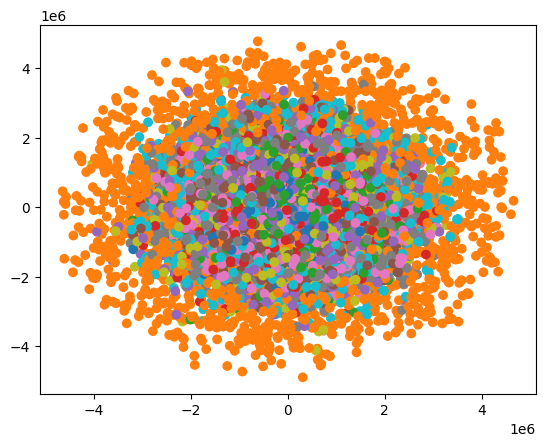

  6%|▌         | 6/100 [02:25<37:45, 24.11s/it]

Iteration 6 KL divergence is 60607561.20151394


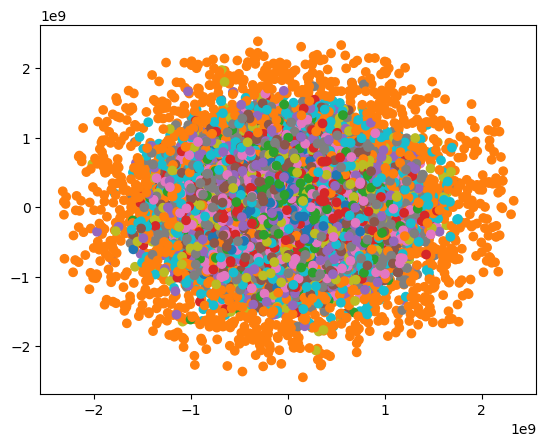

  7%|▋         | 7/100 [02:48<36:35, 23.61s/it]C:\Users\koola\AppData\Local\Temp\ipykernel_49616\2067033929.py:82: RuntimeWarning: divide by zero encountered in divide
  Q[j] = 1 / (1 + dist)
C:\Users\koola\AppData\Local\Temp\ipykernel_49616\2067033929.py:84: RuntimeWarning: invalid value encountered in divide
  Q = Q / Q.sum()


Iteration 7 KL divergence is nan


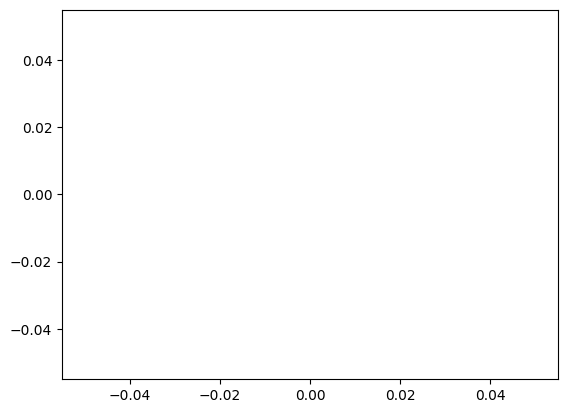

  8%|▊         | 8/100 [03:10<35:45, 23.32s/it]

Iteration 8 KL divergence is nan


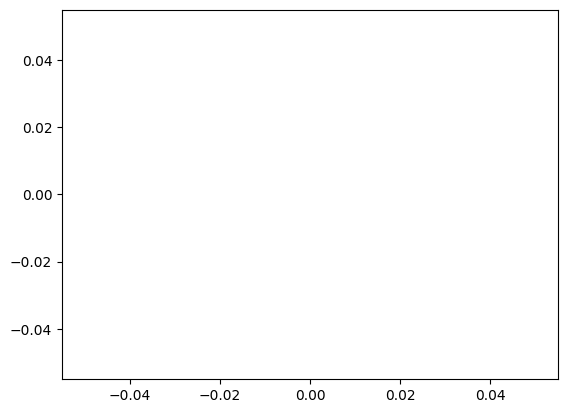

  9%|▉         | 9/100 [03:55<39:37, 26.12s/it]


KeyboardInterrupt: 

In [21]:
# pseudocode: 

# load mnist into matrix X
x = mnist.data.numpy().reshape(-1, 28*28)
y = mnist.targets.numpy()

# sample n images 
n = 20000
np.random.seed(0)
idx = np.random.choice(len(x), n)
x = x[idx]
print(x.shape)

# prep X: 0-1 range; the 0-mean
x = x / 255
x = x - x.mean(axis=0)

# run PCA to 50 dimensions

pca = PCA(n_components=50)
x_pca = pca.fit_transform(x)

# compute pairwise distance matrix D

D = pairwise_distances(x_pca)

# compute similarities p_ij for each row i:
P = np.zeros((n, n))
for i in range(n):
    beta = 0.6
    D_i = D[i, :]
    P_i = np.zeros((1,n))
    # binary like search for beta(i)
    trials = 0
    hdiff = 1
    betamin = -np.inf
    betamax = np.inf
    while(np.abs(hdiff) > 1e-5 and trials < 50):
        P_i = np.exp(-D_i * beta)
        betac = (betamin + betamax) / 2
        h = np.sum(np.exp(-D_i * betac))
        hdiff = h - beta
        if hdiff > 0:
            betamin = betac
        else:
            betamax = betac
        trials += 1
    beta = betac
    P[i, :] = P_i  

#make sure P is correct
for i in range(n):
    if np.abs(P[i].sum() - 1) > 1e-5:
        print("Row", i, "does not sum to 1")
        break
    if np.abs(P[i] - P[i].T).sum() > 1e-5:
        print("Row", i, "is not symmetric")
        break
    if P[i,i] > 1e-5:
        print("Row", i, "has a diagonal element greater than 0")
        break
constKL = sum(P * np.log(P))

# initialize tSNE
max_iter = 100
epsilon = 500
min_gain = 0.01
Y = np.random.randn(n, 2)
dY = np.zeros((n, 2))
iY = np.zeros((n, 2))
gains = np.ones((n, 2))

# run tSNE
for i in tqdm(range(max_iter)):
    
    # compute Q
    Y2 = Y**2
    sum_Y2 = np.sum(Y2, axis=1)
    Q = np.zeros((n, n))
    for j in range(n):
        dist = sum_Y2 - 2 * np.dot(Y, Y[j]) + sum_Y2[j]
        Q[j] = 1 / (1 + dist)
    
    Q = Q / Q.sum()
    Q = np.maximum(Q, 1e-12)
    
    # compute dY
    PQ = P - Q
    for k in range(n):
        dY[k] = np.sum(np.tile(PQ[:, k] * Q[:, k], (2, 1)).T * (Y[k] - Y), axis=0)
    
    
    # perform the update
    if i == 0:
        gains = np.sign(dY) != np.sign(iY)
    else:
        gains[gains > 20] = 20
        gains[gains < 0.01] = 0.01
    iY = epsilon * iY - 0.2 * gains * dY
    Y = Y + iY
    Y = Y - np.tile(np.mean(Y, axis=0), (n, 1))
    
    # compute the KL divergence
    C = np.sum(P * np.log(P / Q))
    print("Iteration", i, "KL divergence is", C)
    plt.scatter(Y[:, 0], Y[:, 1], c=y[idx], cmap='tab10')
    plt.show()
    